In [41]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt

In [42]:
num_classes = 2

In [70]:
tf.random.set_seed(12)

In [71]:
modelo_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [72]:
for layer in modelo_base.layers:
   layer.trainable = False

In [73]:
modelo = tf.keras.Sequential(
     [modelo_base,
     GlobalAveragePooling2D(),
     Dense(1024, activation = 'relu'),
     Dense(num_classes, activation ='softmax')
    ])

In [74]:
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [75]:
path = 'E:/visao_am/arquivos/dc_small/'

In [76]:
def cria_dataframe(caminho):
    arquivos =[]
    rotulos = []
    for arquivo in os.listdir(caminho):
        if arquivo.startswith('cat'):
            rotulos.append('cat')
        elif arquivo.startswith('dog'):
            rotulos.append('dog')
        arquivos.append(arquivo)
    return pd.DataFrame({'arquivo': arquivos, 'rotulo': rotulos})

In [77]:
df_dados = cria_dataframe(os.path.join(path, 'train'))

In [78]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   arquivo  2000 non-null   object
 1   rotulo   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [79]:
df_dados.tail(10)

arquivo rotulo
1990  dog.990.jpg    dog
1991  dog.991.jpg    dog
1992  dog.992.jpg    dog
1993  dog.993.jpg    dog
1994  dog.994.jpg    dog
1995  dog.995.jpg    dog
1996  dog.996.jpg    dog
1997  dog.997.jpg    dog
1998  dog.998.jpg    dog
1999  dog.999.jpg    dog

In [80]:
train_df, validation_df = train_test_split(df_dados, test_size=0.2, stratify=df_dados['rotulo'], random_state = 12)


In [81]:
test_df = cria_dataframe(os.path.join(path, 'test1'))

In [82]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [83]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=os.path.join(path, 'train'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 1600 validated image filenames belonging to 2 classes.


In [84]:
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=os.path.join(path, 'train'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 400 validated image filenames belonging to 2 classes.


In [85]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=os.path.join(path, 'test1'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 1000 validated image filenames belonging to 2 classes.


In [86]:
modelo.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 60s 1s/step - loss: 0.2561 - accuracy: 0.9438 - val_loss: 0.0996 - val_accuracy: 0.9714
Epoch 2/5
50/50 [==============================] - 58s 1s/step - loss: 0.0696 - accuracy: 0.9781 - val_loss: 0.0452 - val_accuracy: 0.9818
Epoch 3/5
50/50 [==============================] - 58s 1s/step - loss: 0.0108 - accuracy: 0.9950 - val_loss: 0.0319 - val_accuracy: 0.9896
Epoch 4/5
50/50 [==============================] - 58s 1s/step - loss: 0.0052 - accuracy: 0.9994 - val_loss: 0.0174 - val_accuracy: 0.9948
Epoch 5/5
50/50 [==============================] - 58s 1s/step - loss: 8.1014e-04 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9948


In [87]:
test_loss, test_accuracy = modelo.evaluate(test_generator, steps = test_generator.samples // test_generator.batch_size)
print(f'Acurácia no teste: {test_accuracy}')

31/31 [==============================] - 29s 925ms/step - loss: 0.0590 - accuracy: 0.9808
Acurácia no teste: 0.9808467626571655


In [88]:
modelo.save(path + 'tl_resnet50_5_epoch.keras')

In [89]:
dir_origem = 'E:/visao_am/arquivos/dc_small/amostras/'

In [90]:
def predicao_img(imagem, modelo):
    img = image.load_img(imagem, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array = preprocess_input(img_array)

    predicoes = modelo.predict(img_array)
    classes = {0: 'cat', 1: 'dog'}
    classe_predita = classes[np.argmax(predicoes[0])]

    return classe_predita, img

In [91]:
amostras = [os.path.join(dir_origem, f) \
            for f in os.listdir(dir_origem) \
            if f.endswith(('.jfif', '.webp'))]

In [92]:
amostras

['E:/visao_am/arquivos/dc_small/amostras/cao1.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao10.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao2.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao3.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao4.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao5.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao6.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao7.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao8.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao9.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/caoEgato.webp',
 'E:/visao_am/arquivos/dc_small/amostras/gato1.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato10.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato2.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato3.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato4.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato5.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato6.jfif',
 'E:/visao_am/arquivos/dc_small/a

1/1 [==============================] - 1s 759ms/step


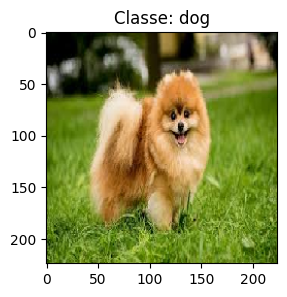

1/1 [==============================] - 0s 69ms/step


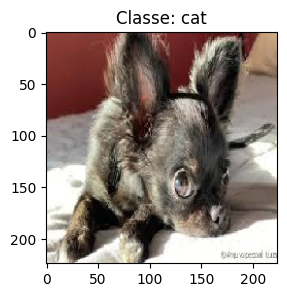

1/1 [==============================] - 0s 68ms/step


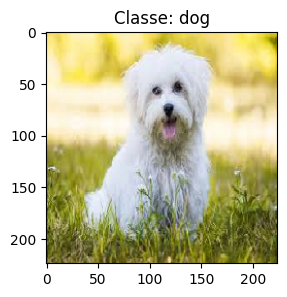

1/1 [==============================] - 0s 80ms/step


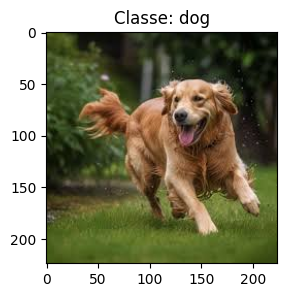

1/1 [==============================] - 0s 81ms/step


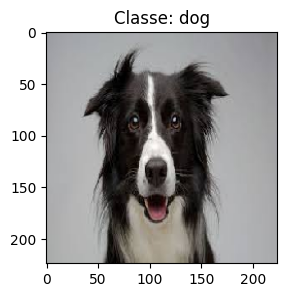

1/1 [==============================] - 0s 74ms/step


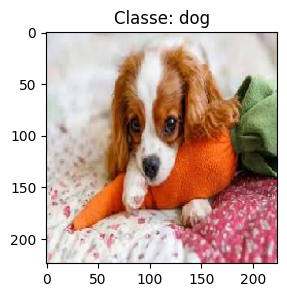

1/1 [==============================] - 0s 88ms/step


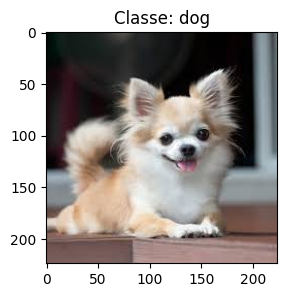

1/1 [==============================] - 0s 73ms/step


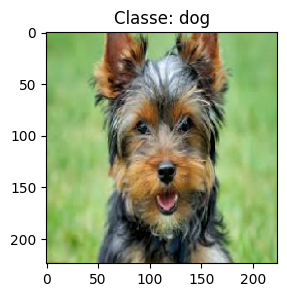

1/1 [==============================] - 0s 82ms/step


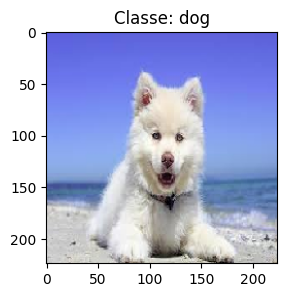

1/1 [==============================] - 0s 74ms/step


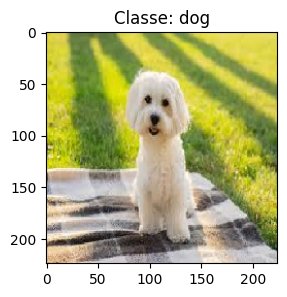

1/1 [==============================] - 0s 100ms/step


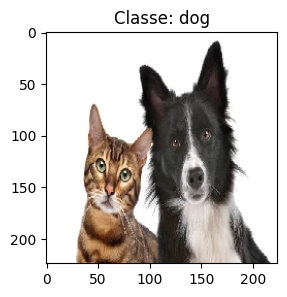

1/1 [==============================] - 0s 100ms/step


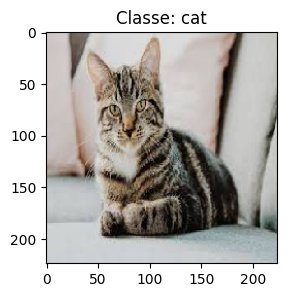

1/1 [==============================] - 0s 90ms/step


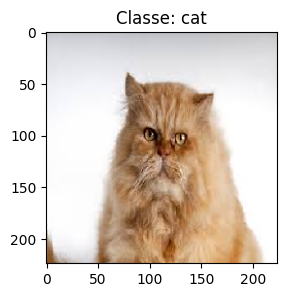

1/1 [==============================] - 0s 75ms/step


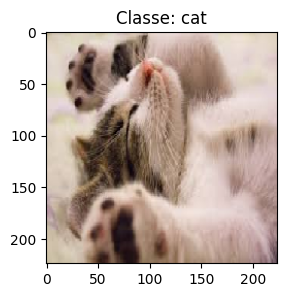

1/1 [==============================] - 0s 73ms/step


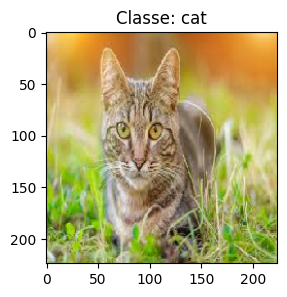

1/1 [==============================] - 0s 67ms/step


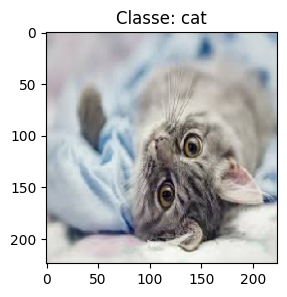

1/1 [==============================] - 0s 73ms/step


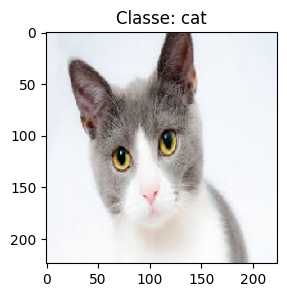

1/1 [==============================] - 0s 74ms/step


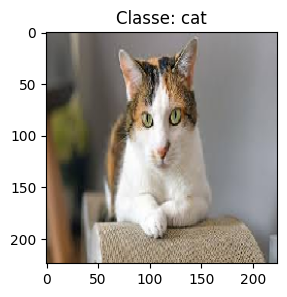

1/1 [==============================] - 0s 67ms/step


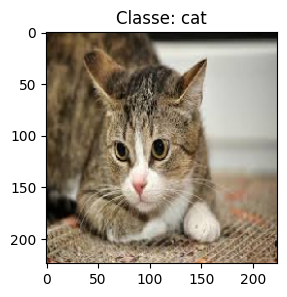

1/1 [==============================] - 0s 67ms/step


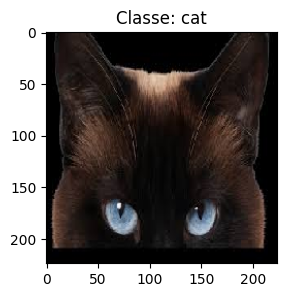

1/1 [==============================] - 0s 99ms/step


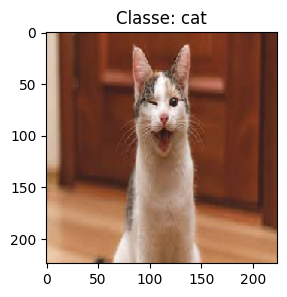

In [93]:
for amostra in amostras:
    classe_predita, img = predicao_img(amostra, modelo)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f'Classe: {classe_predita}')
    plt.show()

verificar etapas do processamento

In [94]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
import datetime
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt

In [95]:
num_classes = 2

In [96]:
tf.random.set_seed(12)

In [97]:
modelo_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [98]:
for layer in modelo_base.layers:
   layer.trainable = False

In [99]:
modelo = tf.keras.Sequential(
     [modelo_base,
     GlobalAveragePooling2D(),
     Dense(1024, activation = 'relu'),
     Dense(num_classes, activation ='softmax')
    ])

In [100]:
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [121]:
log_dir = 'E:/visao_am/arquivos/dc_small/logs/fit' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [122]:
callbacks= [tensorboard_callback]

In [123]:
def cria_dataframe(caminho):
    arquivos =[]
    rotulos = []
    for arquivo in os.listdir(caminho):
        if arquivo.startswith('cat'):
            rotulos.append('cat')
        elif arquivo.startswith('dog'):
            rotulos.append('dog')
        arquivos.append(arquivo)
    return pd.DataFrame({'arquivo': arquivos, 'rotulo': rotulos})

In [124]:
df_dados = cria_dataframe(os.path.join(path, 'train'))

In [125]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   arquivo  2000 non-null   object
 1   rotulo   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [126]:
df_dados.tail(10)

arquivo rotulo
1990  dog.990.jpg    dog
1991  dog.991.jpg    dog
1992  dog.992.jpg    dog
1993  dog.993.jpg    dog
1994  dog.994.jpg    dog
1995  dog.995.jpg    dog
1996  dog.996.jpg    dog
1997  dog.997.jpg    dog
1998  dog.998.jpg    dog
1999  dog.999.jpg    dog

In [127]:
train_df, validation_df = train_test_split(df_dados, test_size=0.2, stratify=df_dados['rotulo'], random_state = 12)


In [128]:
test_df = cria_dataframe(os.path.join(path, 'test1'))

In [129]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [130]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=os.path.join(path, 'train'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 1600 validated image filenames belonging to 2 classes.


In [131]:
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=os.path.join(path, 'train'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 400 validated image filenames belonging to 2 classes.


In [112]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=os.path.join(path, 'test1'),
    x_col='arquivo',
    y_col='rotulo',
    target_size=(224,224),
    batch_size= 32,
    class_mode='categorical'
)

Found 1000 validated image filenames belonging to 2 classes.


In [133]:
modelo.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
50/50 [==============================] - 62s 1s/step - loss: 6.2055e-05 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9948
Epoch 2/10
50/50 [==============================] - 63s 1s/step - loss: 4.8736e-05 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9948
Epoch 3/10
50/50 [==============================] - 62s 1s/step - loss: 5.0836e-05 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9948
Epoch 4/10
50/50 [==============================] - 62s 1s/step - loss: 3.7488e-05 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9948
Epoch 5/10
50/50 [==============================] - 61s 1s/step - loss: 3.0890e-05 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9948
Epoch 6/10
50/50 [==============================] - 62s 1s/step - loss: 2.5041e-05 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9948
Epoch 7/10
50/50 [==============================] - 62s 1s/step - loss: 2.0972e-05 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy:

In [134]:
test_loss, test_accuracy = modelo.evaluate(test_generator, steps = test_generator.samples // test_generator.batch_size)
print(f'Acurácia no teste: {test_accuracy}')

31/31 [==============================] - 29s 927ms/step - loss: 0.0934 - accuracy: 0.9839
Acurácia no teste: 0.9838709831237793


In [135]:
%load_ext tensorboard

In [136]:
tensorboard --logdir 'E:/visao_am/arquivos/dc_small/logs/'

In [ ]:
tensor_board --logdir= path +'logs/fit

In [88]:
modelo.save(path + 'tl_resnet50_5_epoch.keras')

In [89]:
dir_origem = 'E:/visao_am/arquivos/dc_small/amostras/'

In [90]:
def predicao_img(imagem, modelo):
    img = image.load_img(imagem, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)
    img_array = preprocess_input(img_array)

    predicoes = modelo.predict(img_array)
    classes = {0: 'cat', 1: 'dog'}
    classe_predita = classes[np.argmax(predicoes[0])]

    return classe_predita, img

In [91]:
amostras = [os.path.join(dir_origem, f) \
            for f in os.listdir(dir_origem) \
            if f.endswith(('.jfif', '.webp'))]

In [92]:
amostras

['E:/visao_am/arquivos/dc_small/amostras/cao1.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao10.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao2.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao3.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao4.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao5.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao6.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao7.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao8.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/cao9.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/caoEgato.webp',
 'E:/visao_am/arquivos/dc_small/amostras/gato1.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato10.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato2.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato3.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato4.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato5.jfif',
 'E:/visao_am/arquivos/dc_small/amostras/gato6.jfif',
 'E:/visao_am/arquivos/dc_small/a

1/1 [==============================] - 1s 759ms/step


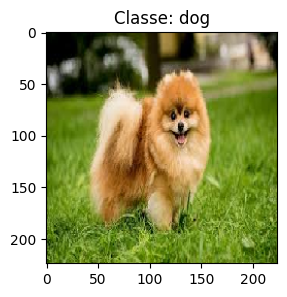

1/1 [==============================] - 0s 69ms/step


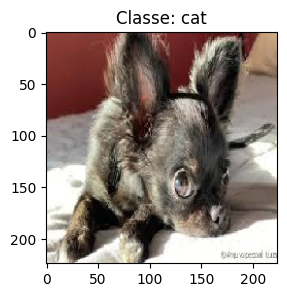

1/1 [==============================] - 0s 68ms/step


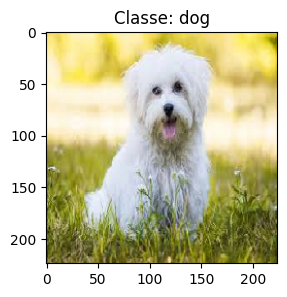

1/1 [==============================] - 0s 80ms/step


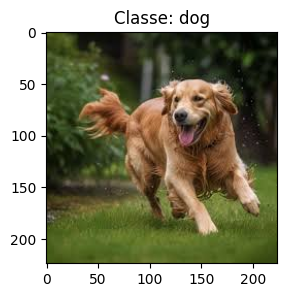

1/1 [==============================] - 0s 81ms/step


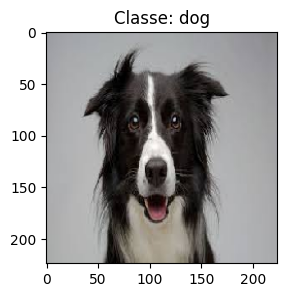

1/1 [==============================] - 0s 74ms/step


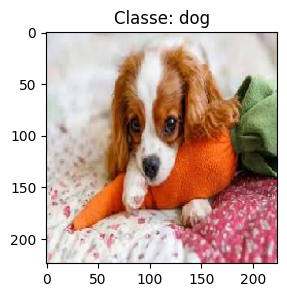

1/1 [==============================] - 0s 88ms/step


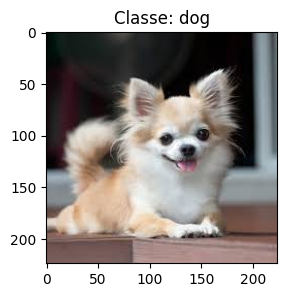

1/1 [==============================] - 0s 73ms/step


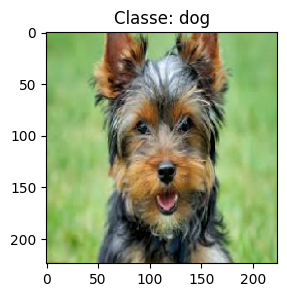

1/1 [==============================] - 0s 82ms/step


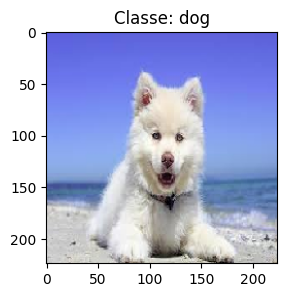

1/1 [==============================] - 0s 74ms/step


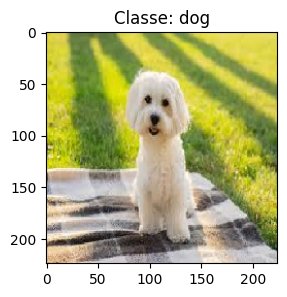

1/1 [==============================] - 0s 100ms/step


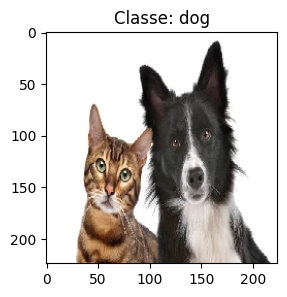

1/1 [==============================] - 0s 100ms/step


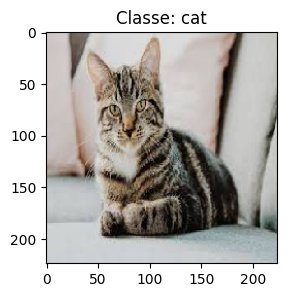

1/1 [==============================] - 0s 90ms/step


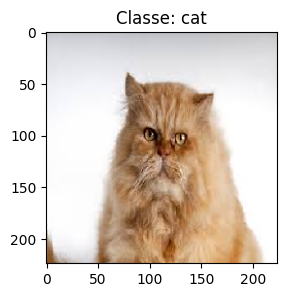

1/1 [==============================] - 0s 75ms/step


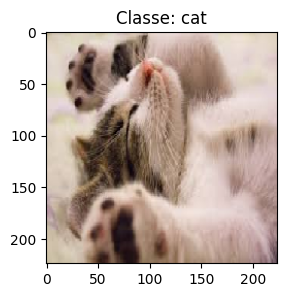

1/1 [==============================] - 0s 73ms/step


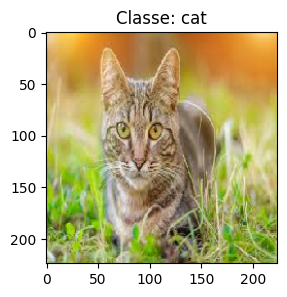

1/1 [==============================] - 0s 67ms/step


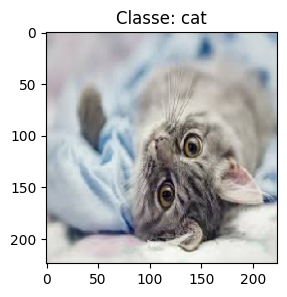

1/1 [==============================] - 0s 73ms/step


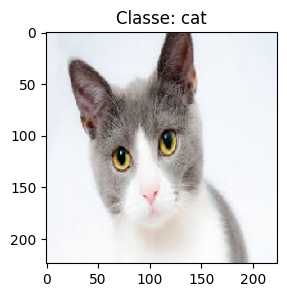

1/1 [==============================] - 0s 74ms/step


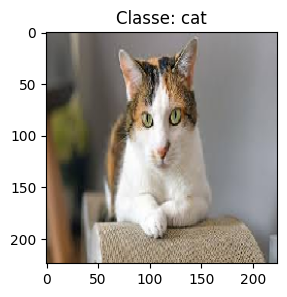

1/1 [==============================] - 0s 67ms/step


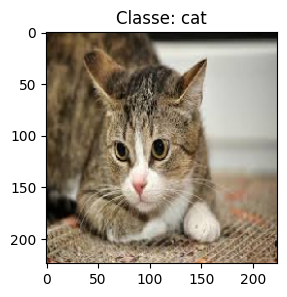

1/1 [==============================] - 0s 67ms/step


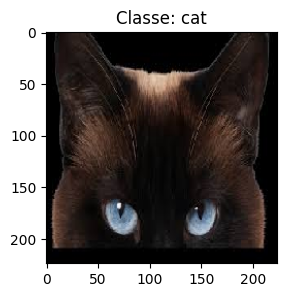

1/1 [==============================] - 0s 99ms/step


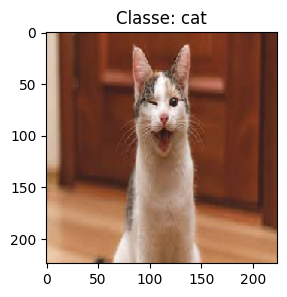

In [93]:
for amostra in amostras:
    classe_predita, img = predicao_img(amostra, modelo)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(f'Classe: {classe_predita}')
    plt.show()